In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from src.model import model
import pandas as pd
import os
import joblib

#load model
seed = 42
my_model = model(seed)
my_model.classifier = joblib.load("src/models/bangerv3.pkl")
print(my_model.classifier)


SVC(class_weight='balanced', kernel='linear', max_iter=1000000,
    probability=True, random_state=42, verbose=1)


In [2]:
from detection import detection_images_in_folder

## detect the images in val  it will sortir an detections.csv
detection_images_in_folder('C:/Users/23158/Desktop/SY32PROJET/dataset2/val/images/', my_model, 'detections.csv')

SVC(class_weight='balanced', kernel='linear', max_iter=1000000,
    probability=True, random_state=42, verbose=1)
0004.jpg
imagesize: 750 1000
windowsize: 675 675
step_size: 135
windowsize: 600 600
step_size: 120
windowsize: 525 525
step_size: 105
windowsize: 450 450
step_size: 90
windowsize: 375 375
step_size: 75
windowsize: 300 300
step_size: 60
windowsize: 225 225
step_size: 45
windowsize: 150 150
step_size: 30
imagesize: 750 1000
windowsize: 409 900
step_size: 180 81
windowsize: 363 800
step_size: 160 72
windowsize: 318 700
step_size: 140 63
windowsize: 272 600
step_size: 120 54
windowsize: 227 500
step_size: 100 45
windowsize: 181 400
step_size: 80 36
windowsize: 136 300
step_size: 60 27
windowsize: 90 200
step_size: 40 18
[]
0039.jpg
imagesize: 715 1000
windowsize: 643 643
step_size: 128
windowsize: 572 572
step_size: 114
windowsize: 500 500
step_size: 100
windowsize: 429 429
step_size: 85
windowsize: 357 357
step_size: 71
windowsize: 286 286
step_size: 57
windowsize: 214 214
ste

KeyboardInterrupt: 

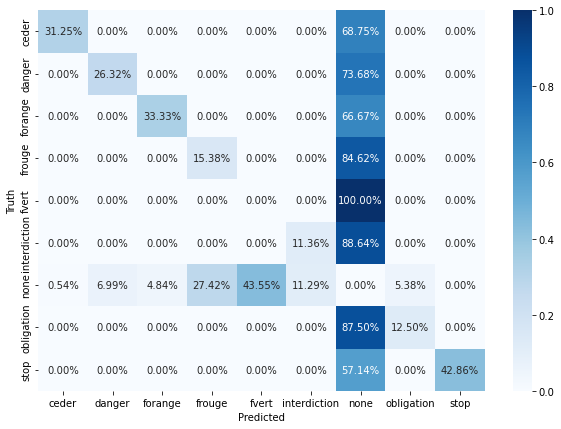

Precision:
 {'ceder': 0.8333333333333334, 'danger': 0.2777777777777778, 'forange': 0.18181818181818182, 'frouge': 0.03773584905660377, 'fvert': 0.0, 'interdiction': 0.19230769230769232, 'none': 0.0, 'obligation': 0.16666666666666666, 'stop': 1.0}

Recall:
 {'ceder': 0.3125, 'danger': 0.2631578947368421, 'forange': 0.3333333333333333, 'frouge': 0.15384615384615385, 'fvert': 0.0, 'interdiction': 0.11363636363636363, 'none': 0.0, 'obligation': 0.125, 'stop': 0.42857142857142855}
27
289
289

precision:
 0.08544303797468354


In [36]:
###get map scores
import pandas as pd

# Load the data
validations = pd.read_csv('validations.csv',header=None)
detections = pd.read_csv('detections.csv',header=None) ### put the results detections.csv we get before

# Filter out the 'ff' labels
validations = validations[validations.iloc[:, 5] != 'ff']
detections = detections[detections.iloc[:, 6] != 'ff']



# Initialize lists to store y (ground truth) and y_pred (predictions)
y = []
y_pred = []
matching_validation_row=[]
fp_data=[]
# Define IoU function
def iou(box1, box2):
    # Unpack the coordinates
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Calculate the intersection area
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Calculate the areas of each box
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate the union area
    union_area = box1_area + box2_area - inter_area

    # Calculate the IoU
    iou = inter_area / union_area

    return iou

# Match detections with ground truth
for _, detection_row in detections.iterrows():
    image_id_d, x_min_d, y_min_d, x_max_d, y_max_d, score_d, label_d = detection_row
    max_iou = 0.5
    matching_validation = 'none'

    for _, validation_row in validations.iterrows():
        image_id_v, x_min_v, y_min_v, x_max_v, y_max_v, label_v = validation_row
        
        if image_id_v == image_id_d and label_v == label_d:
            iou_value = iou((x_min_v, y_min_v, x_max_v, y_max_v), (x_min_d, y_min_d, x_max_d, y_max_d))
            
            if iou_value > max_iou:
                max_iou = iou_value
                matching_validation = label_v
                
                matching_validation_row.append(_)
    
    # Add ground truth and prediction based on maximum IoU
    #if matching_validation:
    
    y_pred.append(label_d)
    y.append(matching_validation)
    
    if matching_validation == 'none':
       fp_data.append(list(detection_row))


#print(len(detections))
#print(len(y_pred))
#print(len(matching_validation_row))
for _, validation_row in validations.iterrows():
    image_id_v, x_min_v, y_min_v, x_max_v, y_max_v, label_v = validation_row
    if _  not in matching_validation_row:
        y.append(label_v)
        y_pred.append('none')
     

#print(len(y_pred))
#print(len(y))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# plot confusion matrix
cm = confusion_matrix(y, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
# Get unique labels
unique_labels = sorted(list(set(y)))

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2%",
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

precision = {}
recall = {}

for i in range(len(unique_labels)):
    cls = unique_labels[i]
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    
    precision[cls] = tp / (tp + fp) if tp + fp > 0 else 0
    recall[cls] = tp / (tp + fn) if tp + fn > 0 else 0

print("Precision:\n", precision)
print("\nRecall:\n", recall)


tp_total = np.sum(np.diag(cm))  
fp_total = np.sum(cm) - tp_total  
fn_total = np.sum(cm) - tp_total  

print(tp_total)
print(fp_total)
print(fn_total)

overall_precision = tp_total / (tp_total + fp_total) if tp_total + fp_total > 0 else 0
overall_recall = tp_total / (tp_total + fn_total) if tp_total + fn_total > 0 else 0

print("\nprecision:\n", overall_precision)


In [37]:
print(fp_data)

[['0004.jpg', 325, 700, 438, 950, 0.947449047, 'fvert'], ['0004.jpg', 375, 550, 443, 700, 0.891092292, 'forange'], ['0004.jpg', 425, 700, 538, 950, 0.851041707, 'fvert'], ['0004.jpg', 275, 750, 343, 900, 0.782412657, 'fvert'], ['0004.jpg', 75, 750, 165, 950, 0.700230944, 'forange'], ['0088.jpg', 250, 100, 318, 250, 0.906129875, 'frouge'], ['0088.jpg', 125, 150, 170, 250, 0.701816243, 'frouge'], ['0091.jpg', 450, 400, 550, 500, 0.955127827, 'danger'], ['0091.jpg', 275, 450, 343, 600, 0.769490125, 'frouge'], ['0101.jpg', 500, 350, 700, 550, 0.924473544, 'interdiction'], ['0132.jpg', 50, 450, 95, 550, 0.71413808, 'fvert'], ['0137.jpg', 500, 350, 545, 450, 0.934290115, 'forange'], ['0137.jpg', 600, 300, 800, 500, 0.903581097, 'interdiction'], ['0145.jpg', 250, 200, 318, 350, 0.944112875, 'frouge'], ['0145.jpg', 275, 750, 365, 950, 0.922704762, 'fvert'], ['0184.jpg', 150, 500, 278, 628, 0.972179007, 'interdiction'], ['0184.jpg', 350, 550, 428, 628, 0.96116054, 'interdiction'], ['0184.jpg', 